In [1]:
from qiskit.quantum_info import random_unitary
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import RZGate, RYGate, XGate
from qiskit.quantum_info import Operator

import numpy as np

Adapted from Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information (10th anniversary ed., p. 181). Cambridge University Press.

#############################################################################

This code creates a multi-control $U$ gate, using only 1 qubit and cx gates, such that:

$$ C^n U \, |x\rangle_n \, |y\rangle_1 = 
\begin{cases} 
|x\rangle_n \, U|y\rangle_1, & \text{if } x = (1, 1, \dots, 1), \\
|x\rangle_n \, |y\rangle_1, & \text{otherwise}.
\end{cases}$$

First, we create a single control unitary gate, cv_gate, using the ZYZ decomposition

Second, we create a toffoli gate. 

Third, we create the multicontrol U gate, following the text.

Lastly, we list the gate count, circuit depth, and ancilla count for low values of n.

#############################################################################

Any unitary can be written using the ZYZ decomposition: 
$$U = e^{i \phi} R_z(\beta) R_y(\gamma) R_z(\delta) = e^{i \alpha}U' = \begin{bmatrix} e^{i(\alpha - \beta / 2 - \delta / 2)}\cos(\gamma /2) & - e^{i(\alpha - \beta / 2 + \delta / 2)}\sin(\gamma / 2) \\ e^{i(\alpha + \beta / 2 - \delta / 2)}\sin(\gamma /2) & e^{i(\alpha + \beta / 2 + \delta / 2)}\cos(\gamma /2) \end{bmatrix}$$

where

$$\implies \alpha = \det(U)/2$$

$$\implies \gamma = 2 \arccos(|a|) \quad \text{where} \quad a = U_{11}$$

Letting $\theta_1 = \beta / 2 - \delta / 2$ and

$\theta_2 = -\beta / 2 + \delta / 2$, we get

$$\implies \beta = -(\theta_1 + \theta_2)$$

$$\implies \delta = \theta_2 - \theta_1$$

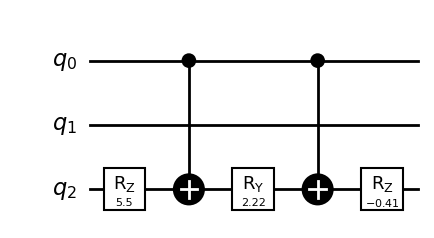

In [9]:
# create cv_gate
def cv_gate(V, qc, control, target):
    """uses 1 qubit gates to construct the ZYZ decomposition of a unitary, V, and contructs a controlled unitary gate"""
    detU = np.linalg.det(U)

    # alpha
    alpha = np.angle(detU) / 2

    # U_prime contains beta, delta, and gamma
    U_prime = U * np.exp(-1j * alpha)

    # select the first (1,1) and (1,2) entry to U'
    a, b = U_prime[0, 0], U_prime[0, 1]

    gamma = 2 * np.arccos(np.abs(a))

    # Fix angles carefully
    theta1 = np.angle(a)  # - (beta + delta)/2
    theta2 = np.angle(b)  # - (beta - delta)/2

    beta = -(theta1 + theta2)
    delta = theta2 - theta1

    # build_ABC_circuit(alpha, beta, gamma, delta)
    A = RZGate(beta)
    B = RYGate(gamma)
    C = RZGate(delta)
    X = XGate()

    # convert to matrix form
    A_mat = Operator(A).data
    B_mat = Operator(B).data
    C_mat = Operator(C).data
    X_mat = Operator(X).data
    
    # insert X between A and B, and between B and C
    U_reconstructed = A_mat @ X_mat @ B_mat @ X_mat @ C_mat
    U_full = np.exp(1j * alpha) * U_reconstructed
    
    # check that U in a 2x2 numpy array
    if not np.allclose(U_full, U, atol=1e-8):
        raise ValueError("ABC decomposition failed")

    qc.rz(beta, target)
    qc.cx(control, target)
    qc.ry(gamma, target)
    qc.cx(control, target)
    qc.rz(delta, target)

    return qc

U = random_unitary(2).data
qc2 = QuantumCircuit(3)  # qubit 0 = control, qubit 1 = target
control = 0
target = 2

qc = cv_gate(U, qc2, control, target)
qc.draw(output="mpl", style="bw")

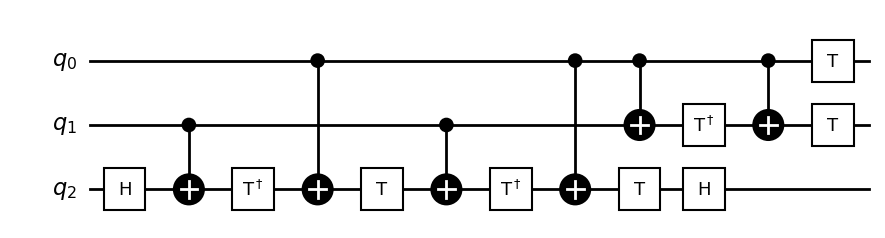

In [5]:
# build the toffoli gate
def toffoli(qc, control1, control2, target):
    """Adds a Toffoli gate using only H, T, T†, and CNOTs."""
    qc.h(target)    
    qc.cx(control2, target)
    qc.tdg(target)
    qc.cx(control1, target)
    qc.t(target)
    qc.cx(control2, target)
    qc.tdg(target)
    qc.cx(control1, target)
    qc.t(target)
    qc.h(target)
    qc.cx(control1, control2)
    qc.tdg(control2)
    qc.cx(control1, control2)
    qc.t(control1)
    qc.t(control2)

    #print(np.real(np.round(np.array(Operator(qc)), 3)).astype(int)) # converting to real integer type just for better readablility

    return qc

qc = QuantumCircuit(3)
toffoli(qc, 0, 1, 2)
qc.draw('mpl', style='bw')

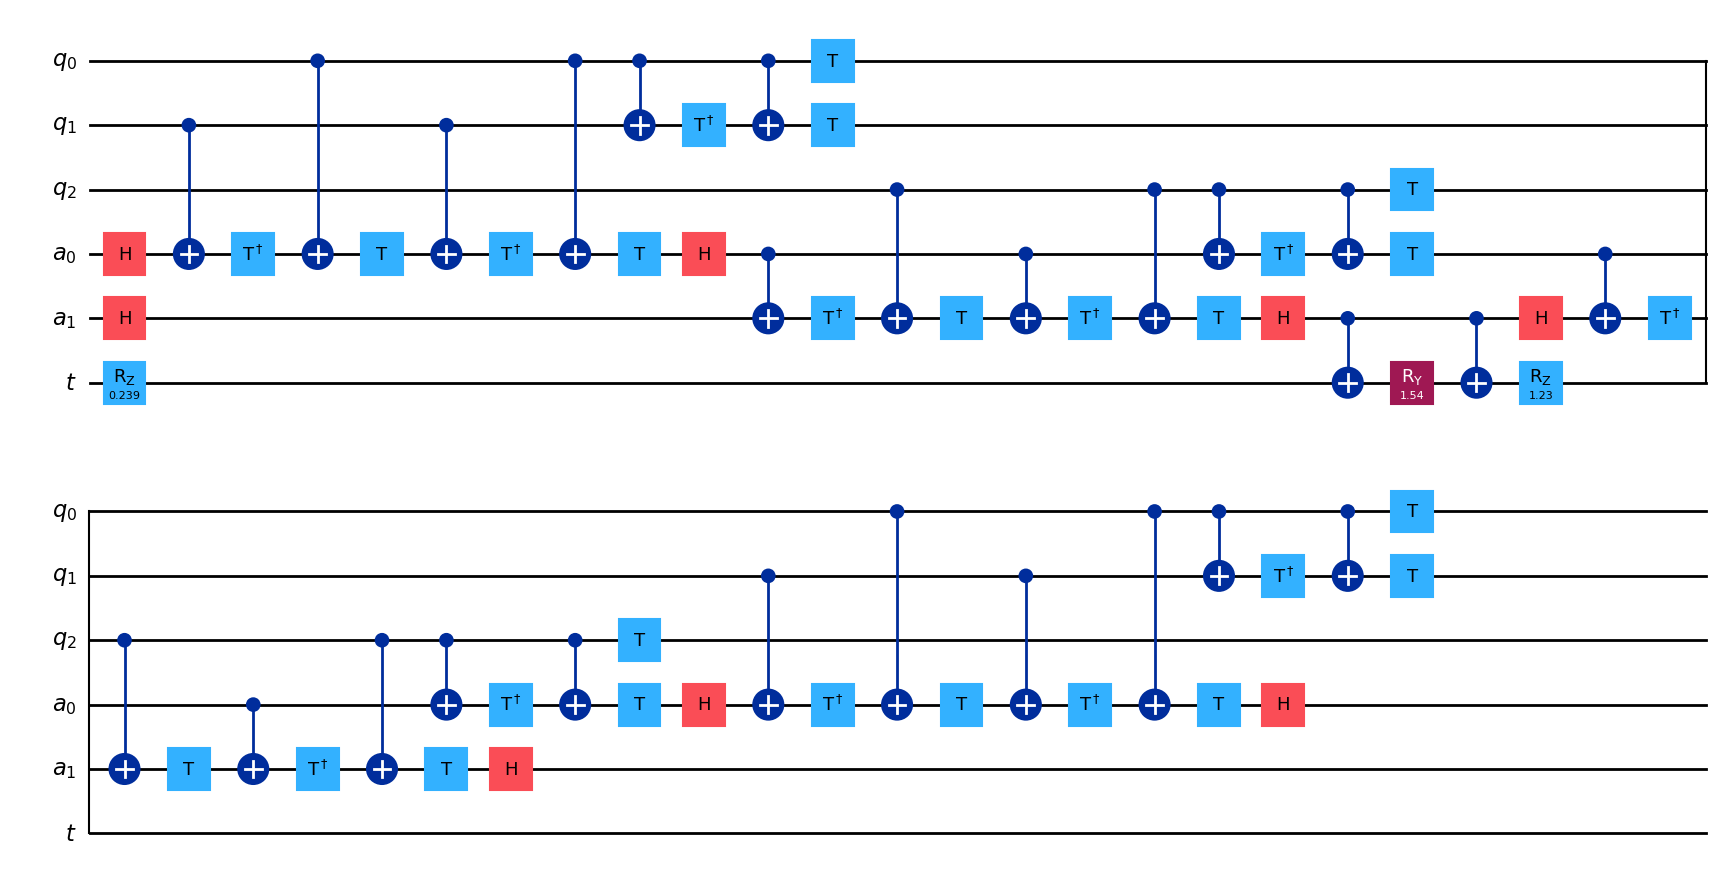

In [10]:
# build C^n U gate with ancillas.
def MCU(n, U):
    ""
    if n == 1:
        controls = QuantumRegister(n, 'q')
        target = QuantumRegister(1, 't')
        qc = QuantumCircuit(controls, target)
        cv_gate(U, qc, controls[0], target)
    else:
        # create a quantum control register with n qubits
        controls = QuantumRegister(n, 'q')
    
        # create ancilla register
        ancilla = AncillaRegister(n - 1, name="a") # same as a QuantumRegister, its purpose is only for bookkeeping
    
        # create a target register with 1 qubit
        target = QuantumRegister(1, 't')
    
        # create the quantum circuit
        qc = QuantumCircuit(controls, ancilla, target)

        # control ancillas by 2 qubits at a time
        toffoli(qc, 0, 1, ancilla[0])
        for i in range(n-2):
            toffoli(qc, i+2, ancilla[i], ancilla[i+1])

        # targets qubit controlled by the all others
        cv_gate(U, qc, ancilla[n-2], target)
    
        # reverse ancilla
        for i in range(n-2):
            toffoli(qc, controls[n-i - 1], ancilla[n - 3 - i], ancilla[n - 2 - i])

        toffoli(qc, 0, 1, ancilla[0])
        
    return qc

# number of qubits
n = 3
U = random_unitary(2).data

qc = MCU(n,U)
qc.draw('mpl')

In [11]:
# benchmarking
for n in range(2, 6):
    U = random_unitary(2).data
    qc = MCU(n, U)  # Already using only basic gates

    gate_count = qc.count_ops()
    depth = qc.depth()
    ancilla_count = qc.num_ancillas

    print(f"n = {n}")
    print(f"Gate count: {gate_count} (Grows as: O(n^2))")
    print(f"Circuit depth: {depth} (Grows as: O(n))")
    print(f"Number of ancillas: {ancilla_count} (Grows as: O(n))")
    print()

n = 2
Gate count: OrderedDict({'cx': 14, 't': 8, 'tdg': 6, 'h': 4, 'rz': 2, 'ry': 1}) (Grows as: O(n^2))
Circuit depth: 25 (Grows as: O(n))
Number of ancillas: 1 (Grows as: O(n))

n = 3
Gate count: OrderedDict({'cx': 26, 't': 16, 'tdg': 12, 'h': 8, 'rz': 2, 'ry': 1}) (Grows as: O(n^2))
Circuit depth: 46 (Grows as: O(n))
Number of ancillas: 2 (Grows as: O(n))

n = 4
Gate count: OrderedDict({'cx': 38, 't': 24, 'tdg': 18, 'h': 12, 'rz': 2, 'ry': 1}) (Grows as: O(n^2))
Circuit depth: 67 (Grows as: O(n))
Number of ancillas: 3 (Grows as: O(n))

n = 5
Gate count: OrderedDict({'cx': 50, 't': 32, 'tdg': 24, 'h': 16, 'rz': 2, 'ry': 1}) (Grows as: O(n^2))
Circuit depth: 88 (Grows as: O(n))
Number of ancillas: 4 (Grows as: O(n))

